In [1]:
from hfpred.utils import get_project_root
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, plot_confusion_matrix

import dataframe_image as dfi
pd.set_option("display.max_columns", None)

# Popular Vote

In [2]:
train = pd.read_csv(
    get_project_root() / "data/heart-processed.csv",
    index_col=0
)
train.drop(columns="train/val", inplace=True)
y_train = train["HeartDisease"]
x_train = train.drop(columns="HeartDisease")

In [3]:
test_set = pd.read_csv(
    get_project_root() / "data/heart-test-set.csv",
    index_col=0
)
y_test = test_set["HeartDisease"]
x_test = test_set.drop(columns="HeartDisease")

In [4]:
scaler = joblib.load(
    get_project_root() / "models/scaler.joblib"
)

In [5]:
scale_cols = [
    "Age",
    "RestingBP",
    "Cholesterol",
    "FastingBS",
    "MaxHR",
    "Oldpeak"
]

x_test[scale_cols] = scaler.fit_transform(x_test[scale_cols])

In [6]:
# x_test.head()

In [7]:
# load the save classifiers:
svc = joblib.load(
    get_project_root() / "models/svc.joblib"
)

rf = joblib.load(
    get_project_root() / "models/rf.joblib"
)

lr = joblib.load(
    get_project_root() / "models/lr.joblib"
)

In [8]:
pred = pd.DataFrame(index=y_test.index)

for mod, model in [("SVM Classifier", svc), ("Random Forest", rf), ("Logistic Regression", lr)]:
    pred[str(mod)] = model.predict(x_test)


In [9]:
svc = SVC(C=0.001, class_weight='balanced', degree=4, kernel='poly')
rf = RandomForestClassifier(max_features='sqrt', min_samples_leaf=5)
lr = LogisticRegression(C=0.1, solver='liblinear')

In [10]:
# np.random.seed(13)
hard_vote = VotingClassifier(
    [
        ("SVM Classifier", svc),
        ("Random Forest", rf),
        ("Logistic Regression", lr)
    ],
    voting="hard",
)

hard_vote.fit(
    x_train,
    y_train
)

VotingClassifier(estimators=[('SVM Classifier',
                              SVC(C=0.001, class_weight='balanced', degree=4,
                                  kernel='poly')),
                             ('Random Forest',
                              RandomForestClassifier(max_features='sqrt',
                                                     min_samples_leaf=5)),
                             ('Logistic Regression',
                              LogisticRegression(C=0.1, solver='liblinear'))])

In [11]:
soft_vote = VotingClassifier(
    [
        ("SVM Classifier", svc),
        ("Random Forest", rf),
        ("Logistic Regression", lr)
    ],
    voting="soft",
)

soft_vote.fit(
    x_train,
    y_train
)

VotingClassifier(estimators=[('SVM Classifier',
                              SVC(C=0.001, class_weight='balanced', degree=4,
                                  kernel='poly')),
                             ('Random Forest',
                              RandomForestClassifier(max_features='sqrt',
                                                     min_samples_leaf=5)),
                             ('Logistic Regression',
                              LogisticRegression(C=0.1, solver='liblinear'))],
                 voting='soft')

In [12]:
pred["hardVote"] = hard_vote.predict(x_test)
# pred["softVote"] = soft_vote.predict_proba(x_test)
pred["Class"] = y_test

In [13]:
pred.tail(50)

,SVM Classifier,Random Forest,Logistic Regression,hardVote,Class
803,1,1,1,1,0
189,1,1,1,1,1
589,1,1,1,1,1
70,1,1,1,1,1
101,0,0,0,0,0
94,0,0,0,0,0
821,0,0,0,0,0
574,1,1,1,1,1
108,0,0,0,0,0
892,1,1,0,0,0


In [14]:
scores = pd.DataFrame()

for metric in [
    ("accuracy", accuracy_score),
    ("recall", recall_score),
    ("precision", precision_score),
    ("f1", f1_score),
    ("ROC_AUC", roc_auc_score)
]:
    scores[f"{metric[0]}"] = [metric[1](y_test, pred.hardVote)]

scores.rename(index={0:"HardVote"}, inplace=True)
scores

,accuracy,recall,precision,f1,ROC_AUC
HardVote,0.92,0.914286,0.914286,0.914286,0.919643


In [15]:
# dfi.export(
#     scores,
#     "../output/tables/pop_vote.png"
# )

In [16]:
cm = confusion_matrix(
    y_test,
    pred["hardVote"]
)
cm

array([[37,  3],
       [ 3, 32]])

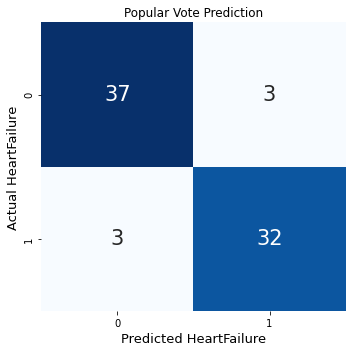

In [17]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

sns.heatmap(
    cm,
    ax=ax1,
    annot=True,
    annot_kws={"size": 21},
    cmap=sns.color_palette("Blues", as_cmap=True),
    cbar=False,
    
)

ax1.set_xlabel("Predicted HeartFailure")
ax1.set_ylabel("Actual HeartFailure")

for text in [
    ax1.xaxis.label,
    ax1.yaxis.label,

]:
    text.set_fontsize(13)

ax1.set_title("Popular Vote Prediction")
fig.tight_layout();

In [18]:
# fig.savefig(
#     get_project_root() / "output/figures/conf_mat.png",
#     dpi=900
# )